# Chapter 4: Deep Convolutional GAN (DCGAN)

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader, RandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [144]:
BATCH_SIZE = 128
NUM_SAMPLES = 128 * 200000
Z_DIM = 100
IMG_ROWS = 28
IMG_COLS = 28

In [145]:
class CustomMnistDataset(Dataset):
    def __init__(self, root, transform=None):
        super(CustomMnistDataset, self).__init__()
        train_set = MNIST(root, train=True, download=True, transform=transform)
        test_set = MNIST(root, train=False, download=True, transform=transform)
        self.dataset = ConcatDataset([train_set, test_set])
        
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        return (image, torch.tensor(1.0))
    
    def __len__(self):
        return len(self.dataset)
            
def get_z_vector(num, length):
    return torch.randn(num, length)

In [146]:
transform = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])
real_dataset = CustomMnistDataset('~/pytorch/', transform=transform)
real_data = DataLoader(real_dataset, batch_size=BATCH_SIZE, 
                       sampler=RandomSampler(real_dataset, num_samples=NUM_SAMPLES, replacement=True), 
                       drop_last=True, num_workers=4)

# Support CUDA

In [147]:
if cuda.is_available():
    print("Using cuda device for training")
    device = 'cuda'
else:
    print("Using cpu for training")
    device = 'cpu'

Using cuda device for training


# Generator

In [148]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, 7 * 7 * 256)
        self.trans1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.trans2 = nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.trans3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = F.leaky_relu(self.linear(x)).view(-1, 256, 7, 7)
        x = F.leaky_relu(self.trans1(x))
        x = self.bn1(x)
        x = F.leaky_relu(self.trans2(x))
        x = self.bn2(x)
        x = torch.tanh(self.trans3(x))
        
        return x
    
generator = Generator(Z_DIM).to(device)

# Discriminator

In [149]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        self.linear = nn.Linear(3 * 3 * 128, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        # x = self.bn1(x)
        x = F.leaky_relu(self.conv3(x))
        # x = self.bn2(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.sigmoid(self.linear(x))
        
        return x

discriminator = Discriminator().to(device)

# Training

In [150]:
d_optim = optim.Adam(params=discriminator.parameters(), lr=0.001)
g_optim = optim.Adam(params=generator.parameters(), lr=0.001)
criterion = nn.BCELoss()

/home/alex/miniconda3/envs/pytorch13/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


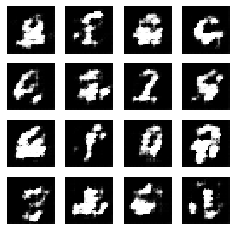

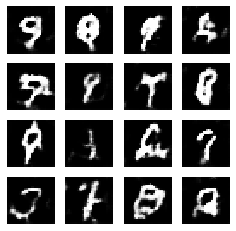

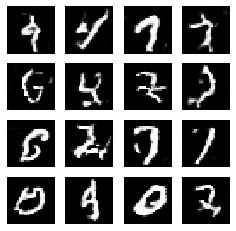

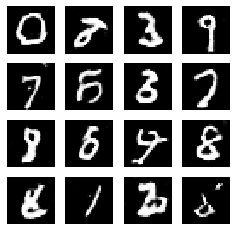

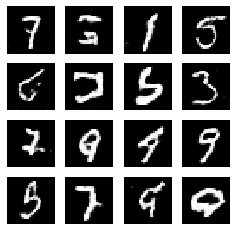

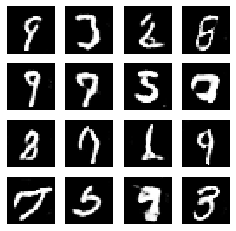

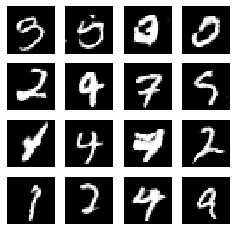

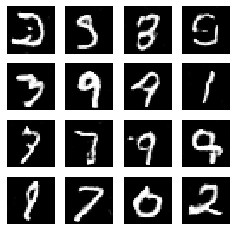

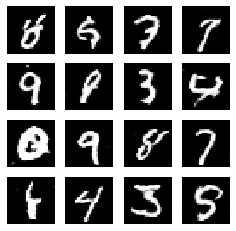

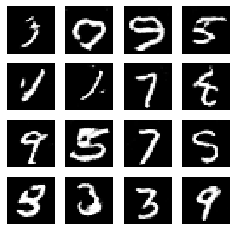

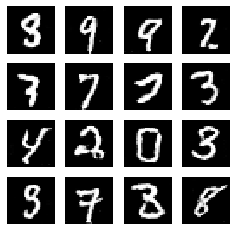

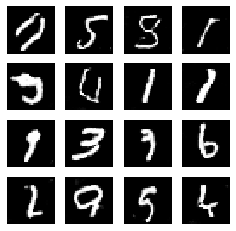

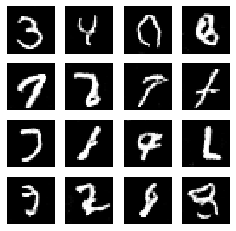

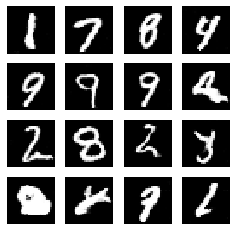

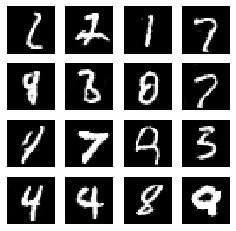

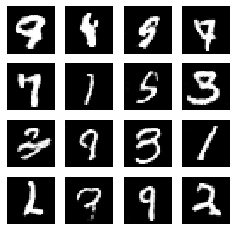

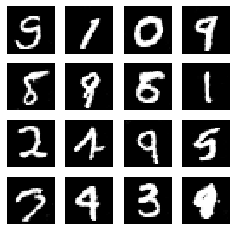

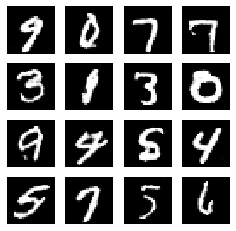

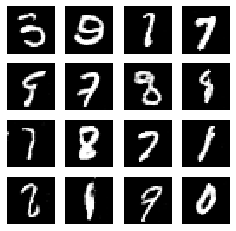

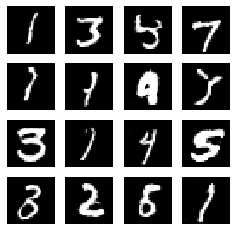

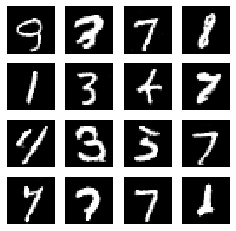

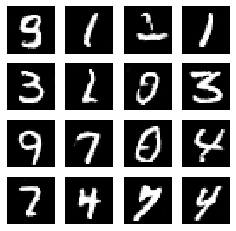

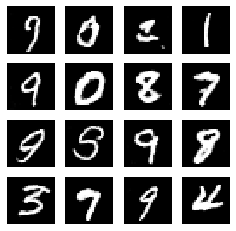

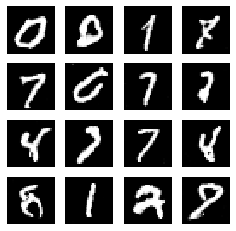

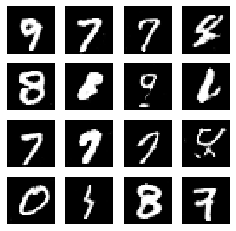

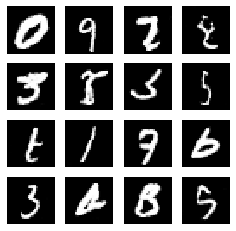

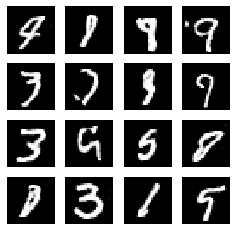

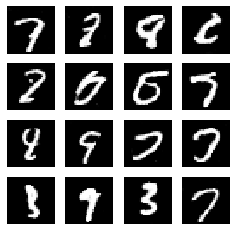

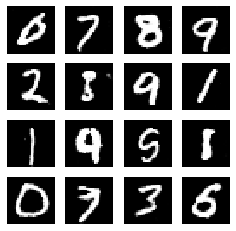

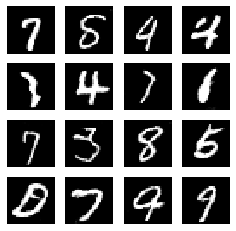

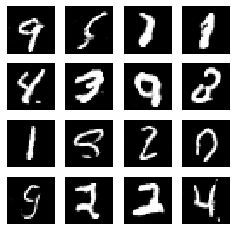

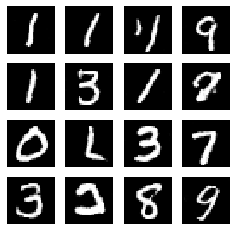

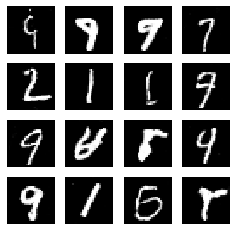

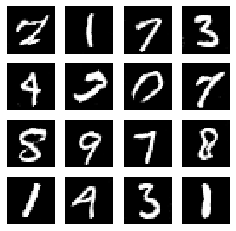

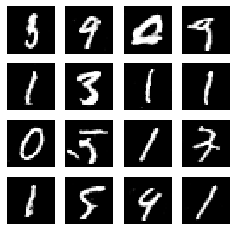

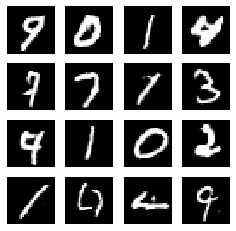

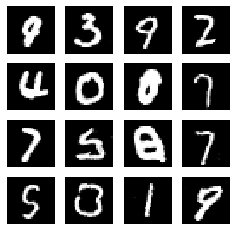

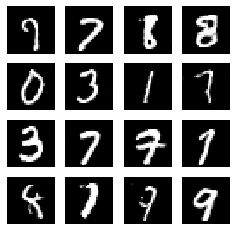

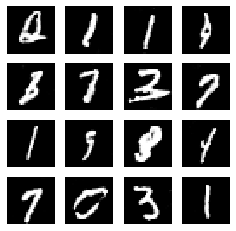

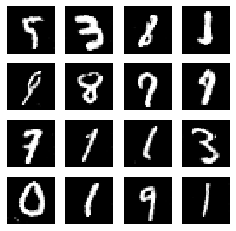

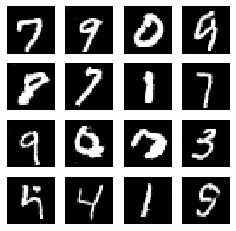

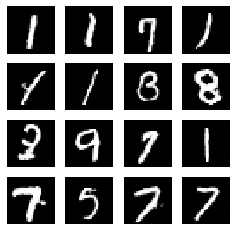

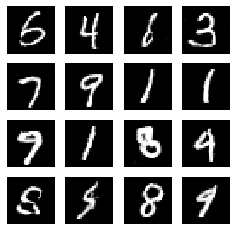

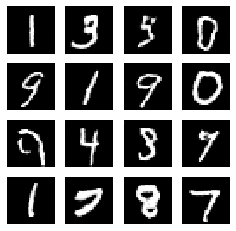

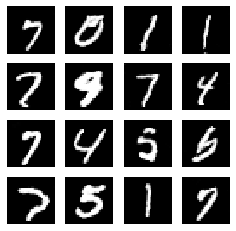

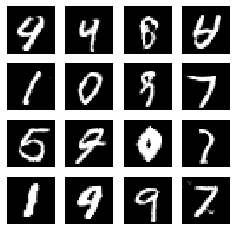

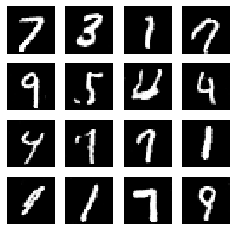

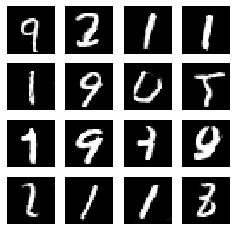

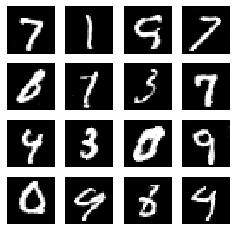

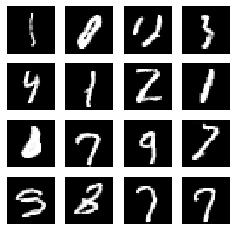

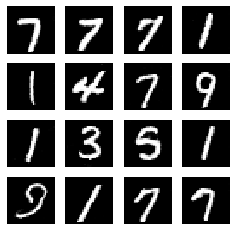

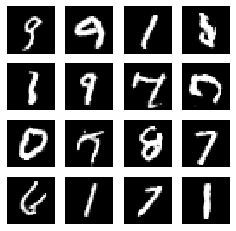

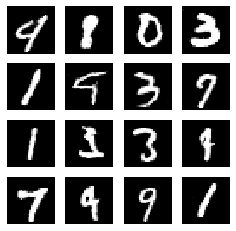

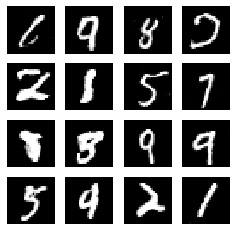

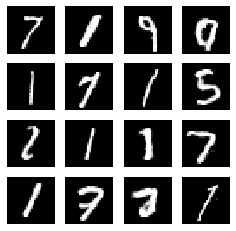

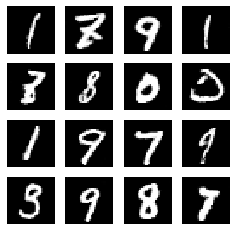

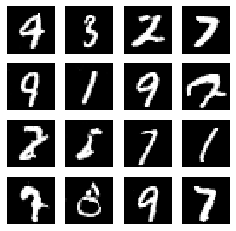

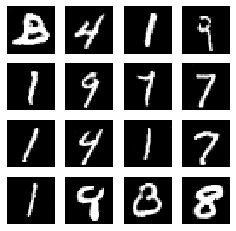

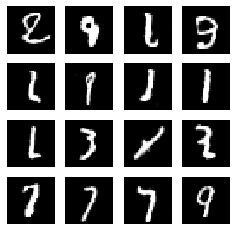

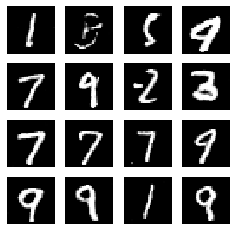

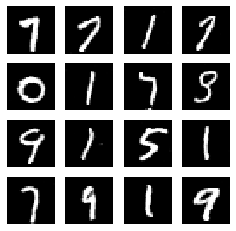

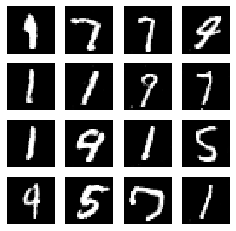

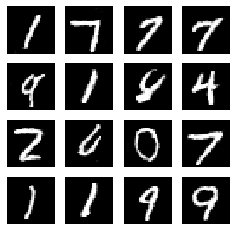

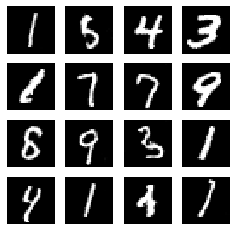

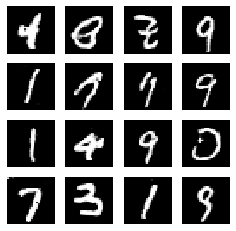

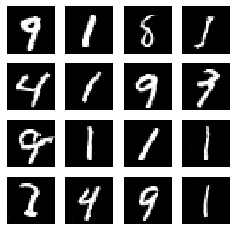

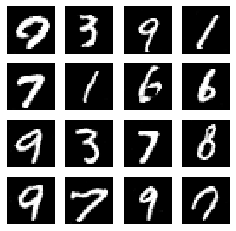

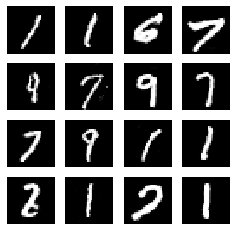

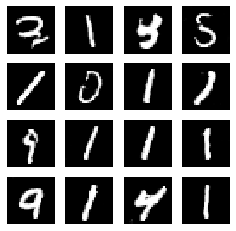

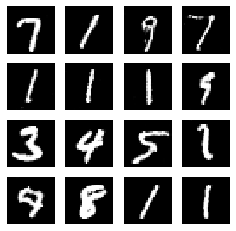

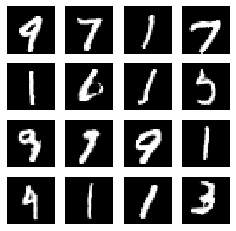

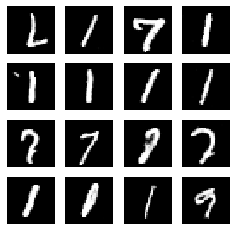

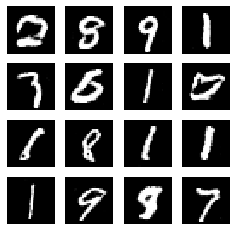

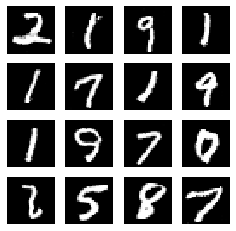

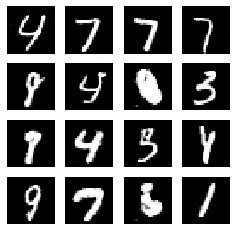

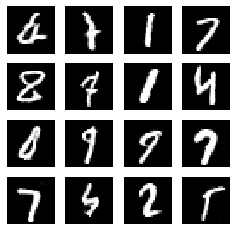

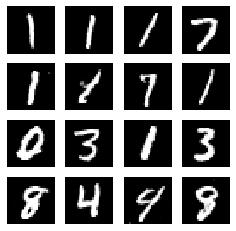

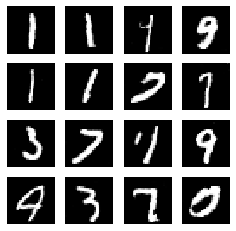

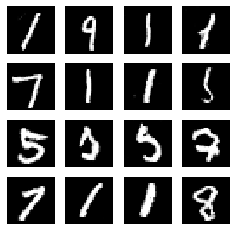

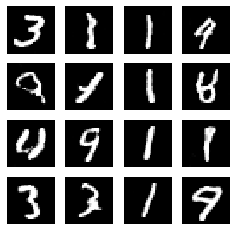

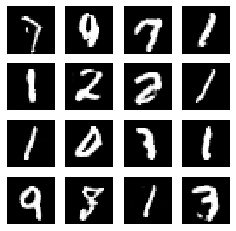

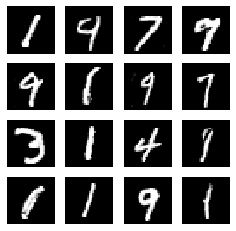

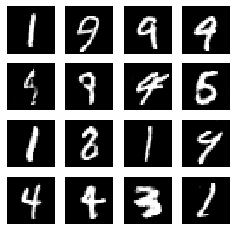

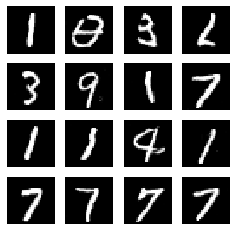

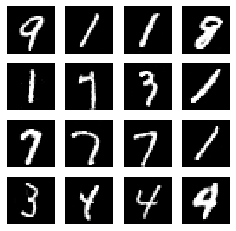

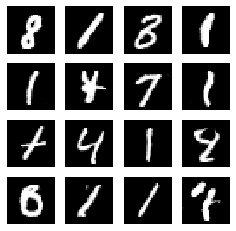

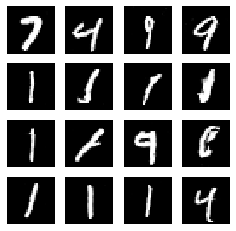

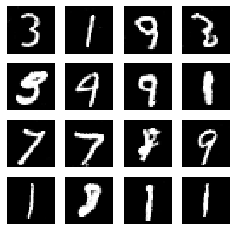

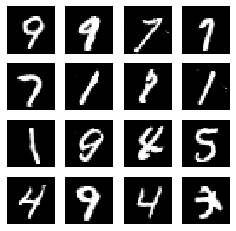

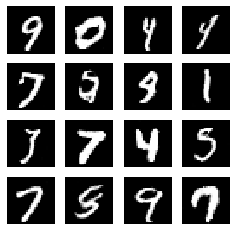

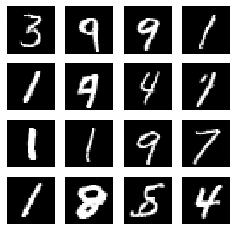

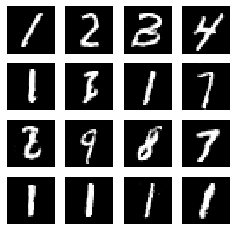

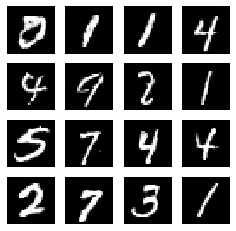

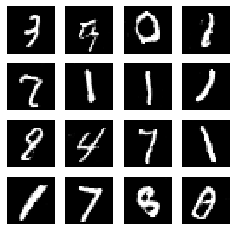

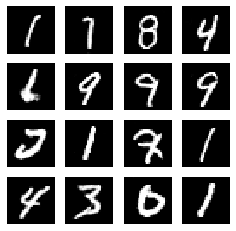

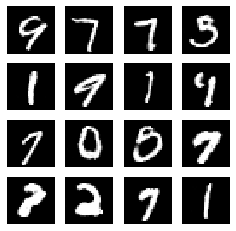

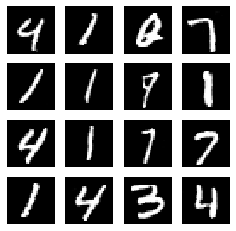

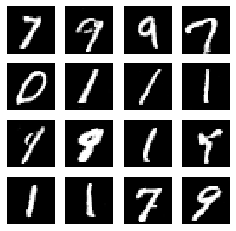

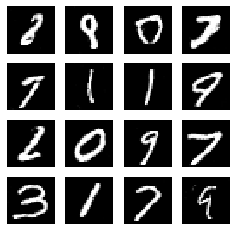

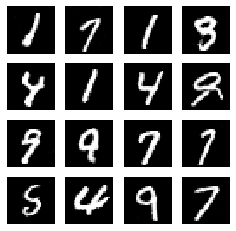

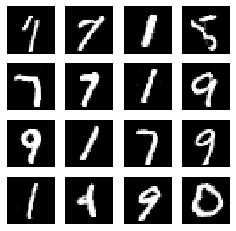

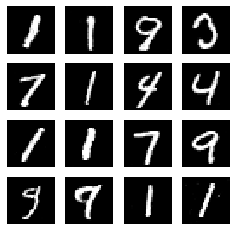

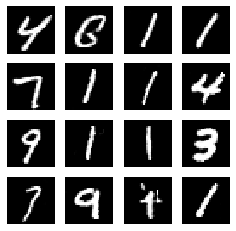

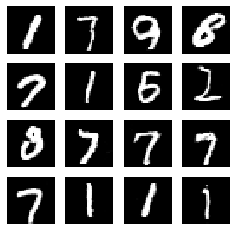

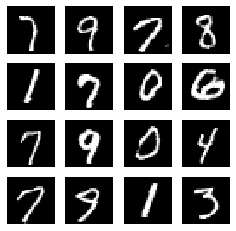

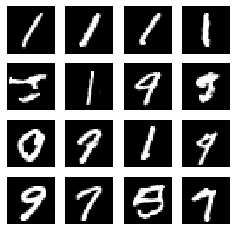

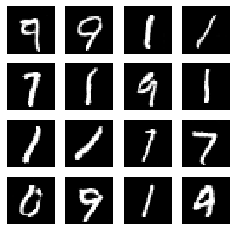

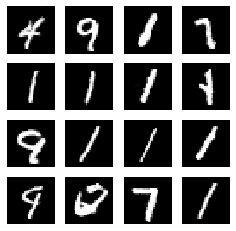

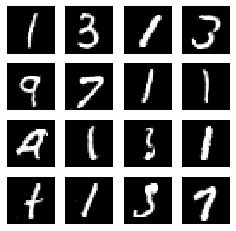

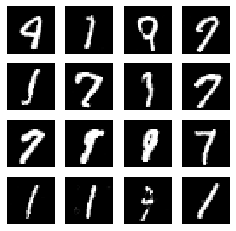

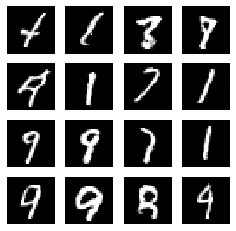

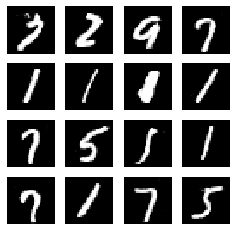

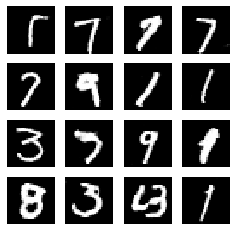

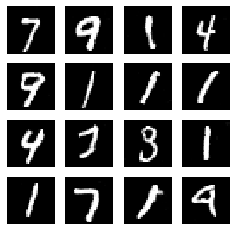

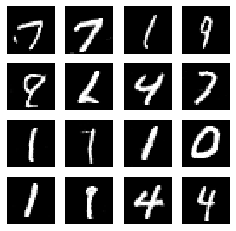

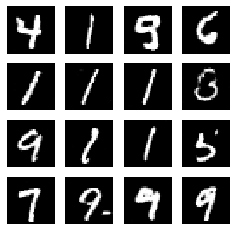

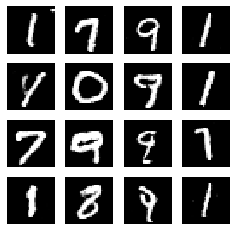

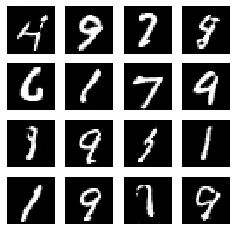

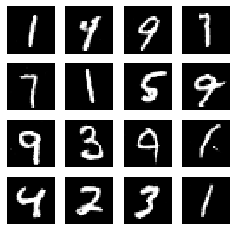

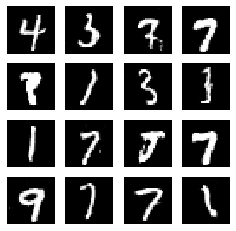

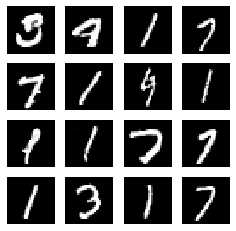

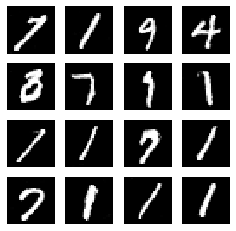

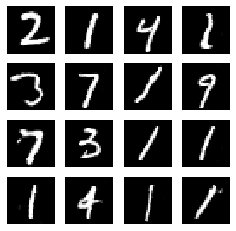

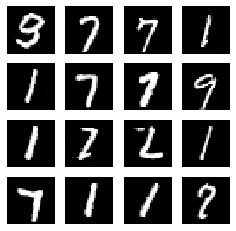

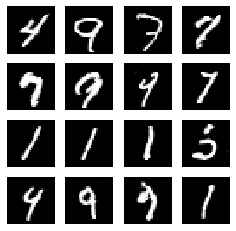

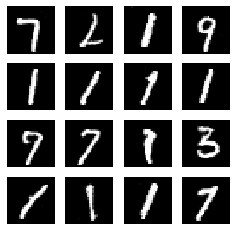

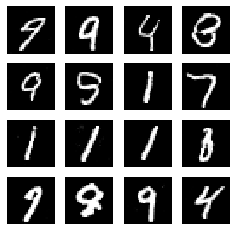

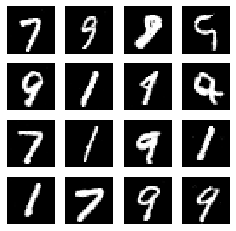

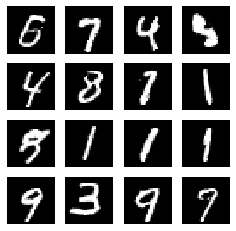

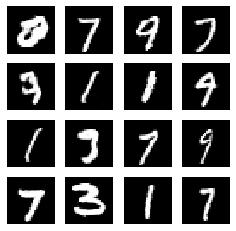

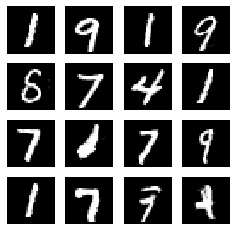

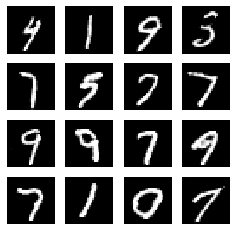

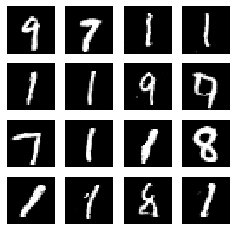

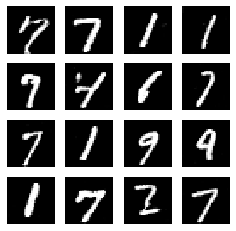

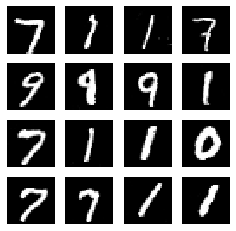

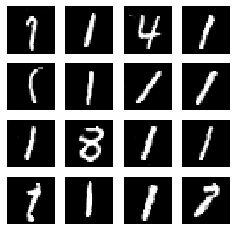

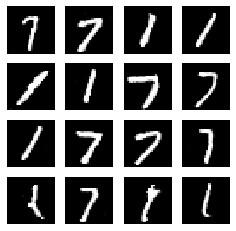

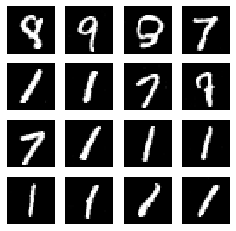

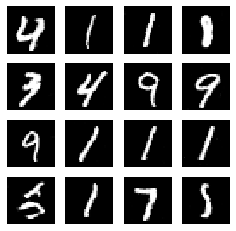

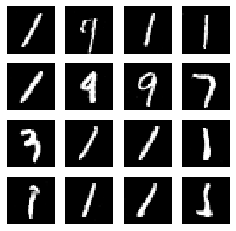

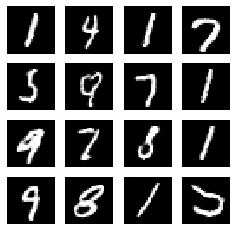

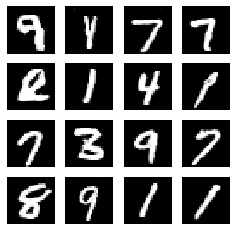

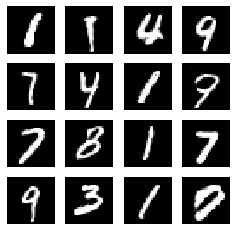

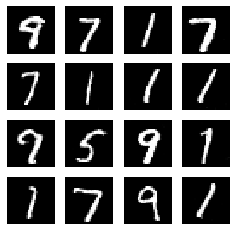

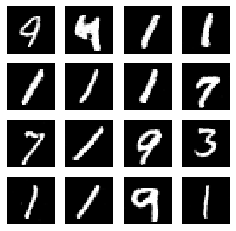

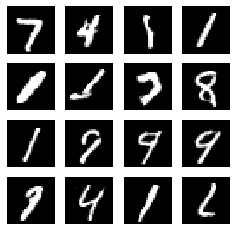

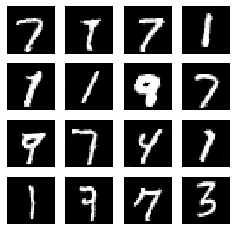

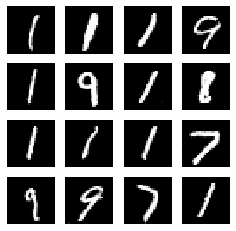

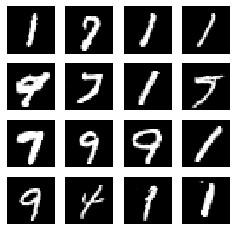

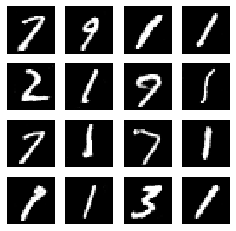

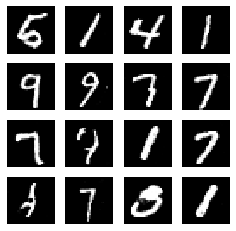

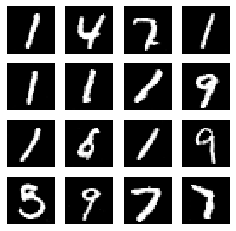

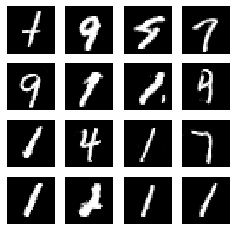

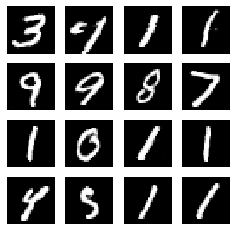

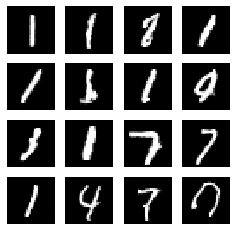

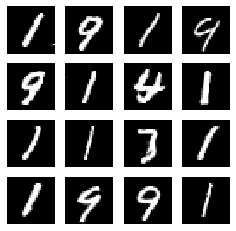

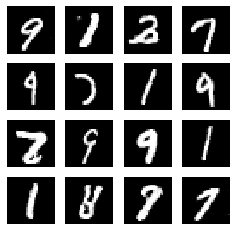

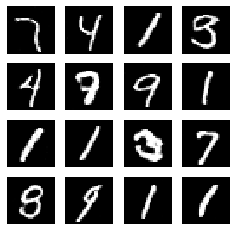

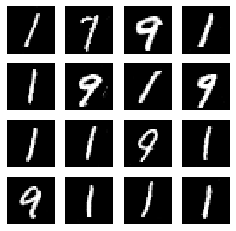

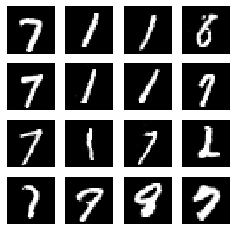

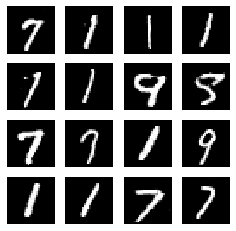

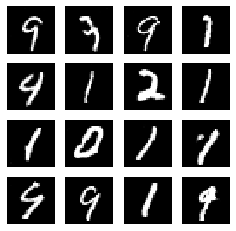

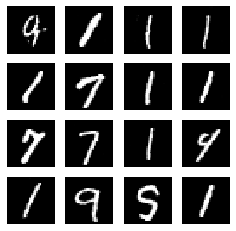

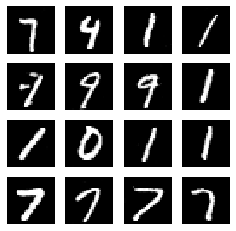

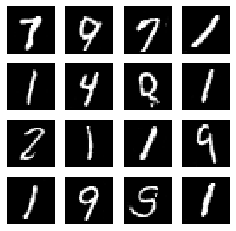

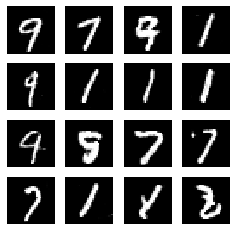

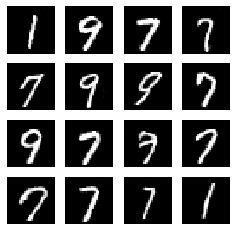

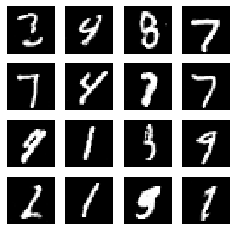

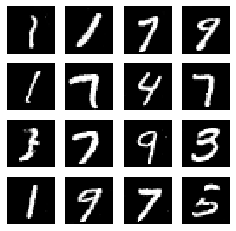

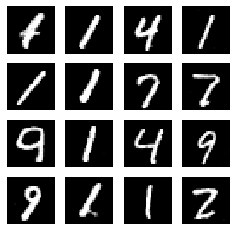

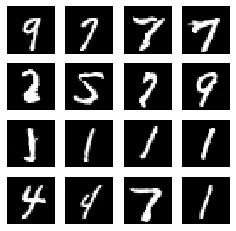

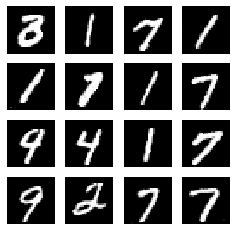

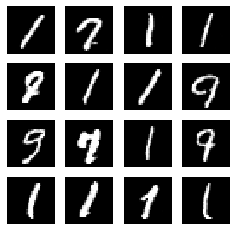

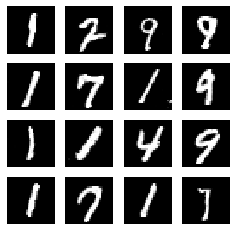

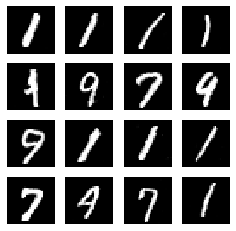

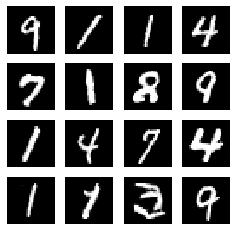

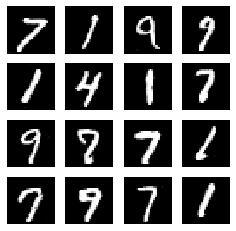

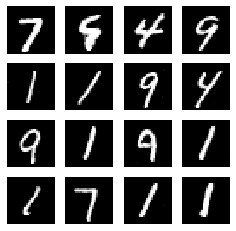

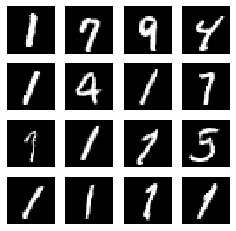

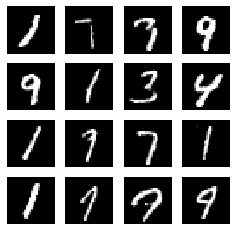

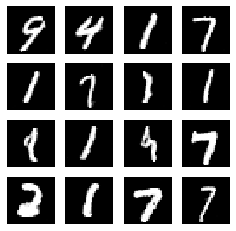

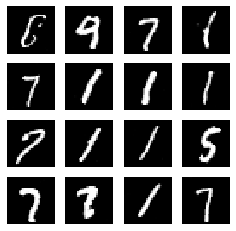

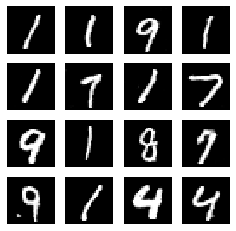

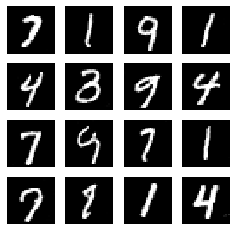

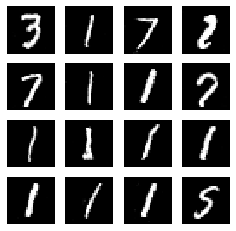

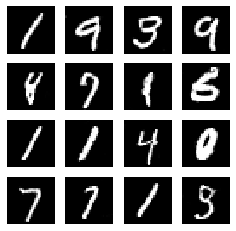

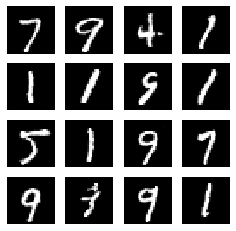

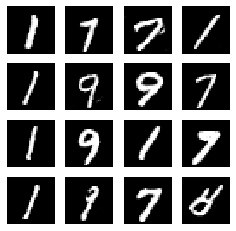

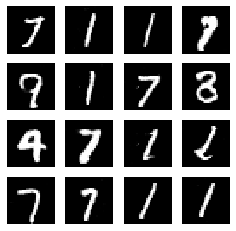

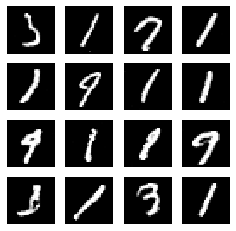

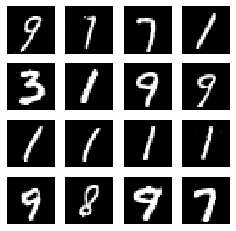

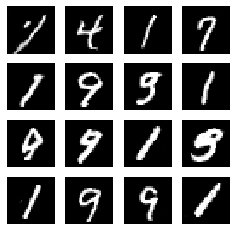

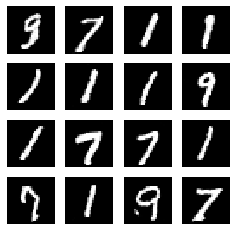

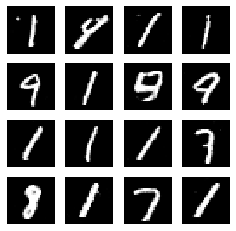

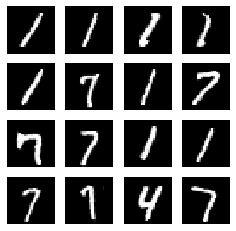

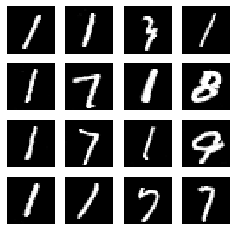

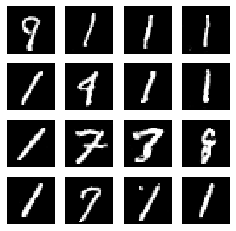

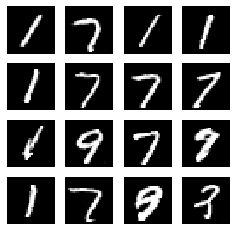

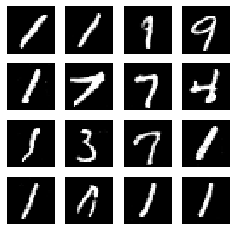

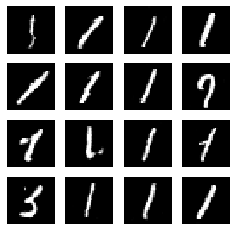

In [151]:
total_gen_loss = 0
total_dis_loss = 0
total_acc = 0
iterations = 0
losses = []
iteration_checkpoints = []

pbar = tqdm(real_data)
for x_real, y_real in pbar:
    # Training discriminator
    # discriminator.train()
    # generator.eval()
    # discriminator.requires_grad_(True)
    # generator.requires_grad_(False)
    x_real = x_real.to(device)
    y_real = y_real.to(device)
    z = get_z_vector(BATCH_SIZE, Z_DIM).to(device)
    y_fake = torch.zeros_like(y_real)
    x_fake = generator(z)

    y_pred_real = discriminator(x_real)
    y_pred_fake = discriminator(x_fake)
    
    loss_real = criterion(y_pred_real, y_real)
    d_optim.zero_grad()
    loss_real.backward()
    d_optim.step()
    
    loss_fake = criterion(y_pred_fake, y_fake)
    d_optim.zero_grad()
    loss_fake.backward()
    d_optim.step()
    
    d_loss = 0.5 * (loss_real + loss_fake)
    total_dis_loss += d_loss.item()
    
    # d_optim.zero_grad()
    # d_loss.backward()
    # d_optim.step()

    # Training generator
    # discriminator.eval()
    # generator.train()
    # discriminator.requires_grad_(False)
    # generator.requires_grad_(True)
    z = get_z_vector(BATCH_SIZE, Z_DIM).to(device)
    x_fake = generator(z)
    y_pred = discriminator(x_fake)
    if iterations % 2 == 1:
        g_loss = -criterion(y_pred, y_fake)
    else:
        g_loss = criterion(y_pred, y_real)
    # g_loss = criterion(y_pred, y_real)
    total_gen_loss += g_loss.item()
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()

    iterations += 1
    if iterations % 1000 == 0:
        losses.append((d_loss, g_loss))
        iteration_checkpoints.append(iterations)
        pbar.set_postfix({"D-loss": "{:.4f}".format(d_loss),
                          "G-loss": "{:.4f}".format(g_loss)})
        sample_images(generator)

In [156]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # Sample random noise
    z = get_z_vector(image_grid_rows * image_grid_columns, Z_DIM).to(device)

    # Generate images from random noise
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z).cpu().detach().view(-1, 28, 28).numpy()
        generator.train()

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(8, 8),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

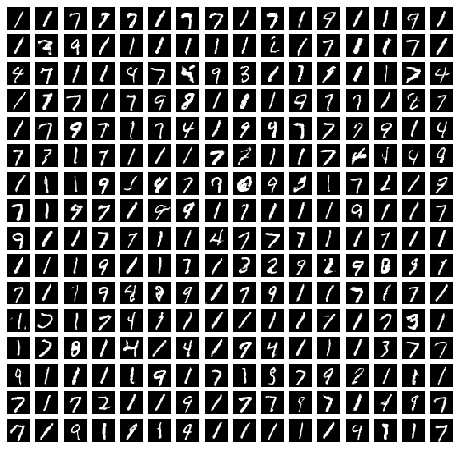

In [157]:
sample_images(generator, 16, 16)

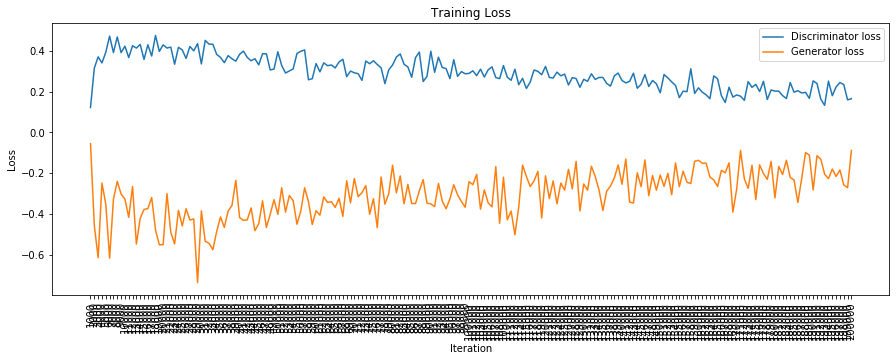

In [153]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()